# Brain Segmentation

This tutorial will show how to use Fed-BioMed to perform image segmentation on 3D medical MRI images of brains, using the publicly available [IXI dataset](https://brain-development.org/ixi-dataset/). 
It uses a [3D U-Net](https://link.springer.com/chapter/10.1007/978-3-319-46723-8_49) model for the segmentation, trained on data from 3 separate centers. 

Here we display a very complex case, using advanced Fed-BioMed functionalities such as:
- loading a `MedicalFolderDataset`
- implementing a custom Node Selection Strategy
- setting a non-default Optimizer
- monitoring training loss with Tensorboard

This tutorial is based on [TorchIO's tutorial](https://colab.research.google.com/github/fepegar/torchio-notebooks/blob/main/notebooks/TorchIO_tutorial.ipynb#scrollTo=OoHXr1a4_9Ll).

### Automatic download and wrangling for the impatient

If you're not interested in the details, you may simply execute the [`download_and_split_ixi.py`](../download_and_split_ixi) script provided by us, as explained below

From your folder execute:
```shell
fedbiomed component create -c researcher
pip install tqdm
python fbm-researcher/notebooks/medical-image-segmentation/download_and_split_ixi.py -f fbm-researcher

```

After successfully running the command, follow the instructions printed to add the datasets and run the nodes. Datasets are located in the nodes' `data` folder (e.g. for `Guys`, it is located into `guys/data`). The tag used for this experiment is `ixi-train`.

## Details about data preparation

If you just want to run the notebook, you may skip this section and skip to `Define a new strategy`.

First, download the IXI dataset from the [Mendeley archive](https://data.mendeley.com/datasets/7kd5wj7v7p).

In this tutorial we are going to use the `MedicalFolderDataset` class provided by the Fed-BioMed library to load medical images in [NIFTI](https://brainder.org/2012/09/23/the-nifti-file-format/) format.
Using this dataset class for image segmentation problems guarantees maximum compatibility with the rest of the Fed-BioMed functionalities and features.

### Folder structure for MedicalFolderDataset

The `MedicalFolderDataset` is heavily inspired by PyTorch's `ImageFolder` Dataset, and requires you to manually prepare the image folders in order to respect a precise structure.
The format assumes that you are dealing with imaging data, possibly acquired through multiple modalities, for different study subjects.
Hence, you should provide one folder per subject, containing multiple subfolders for each image acquisition modality.
Optionally, you may provide a `csv` file containing additional tabular data associated with each subject.
This file is typically used for demographics data, and by default is called `participants.csv`.

```shell
_ root-folder
 |_ participants.csv
 |_ subject-1
 | |_ modality-1
 | |_ modality-2
 |_ subject-2
 | |_ modality-1
 | |_ modality-2
 |_ subject-3
 | |_ modality-1
 . .
 . .
 . .
```

### Folder structure for this tutorial

In the specific case of this tutorial, we encourage you to further divide your images into additional subfolders, according to two criteria: the hospital that generated the data (there are three: Guys, HH and IOP) and a random train/holdout split.

!!! info
    Note that each subject's folder will have a name with the following structure: `IXI<SUBJECT_ID>-<HOSPITAL>-<RANDOM_ID>`, for example `IXI002-Guys-0828`.
    In conclusion, combining the splits above with the structure required by the `MedicalFolderDataset`, your folder tree should look like this:

```shell
_root-folder
 |_ Guys
 | |_ train
 | | |_ participants.csv
 | | |_ IXI002-Guys-0828
 | | | |_ T1                <-- T1 is the first imaging modality
 | | | |_ T2
 | | | |_ label
 | | |_ IXI022-Guys-0701
 | | | |_ T1
 | | | |_ T2
 . . .
 . . .
 . . .
 | |_ holdout
 | | |_ participants.csv
 | | |_ IXI004-Guys-0321
 | | | |_ T1
 | | | |_ T2
 | | | |_ label
 | | | |_ T2
 . . .
 . . .
 . . .
 |_ HH
 | |_ train
 . . .
 . . .
 . . .
 | |_ holdout
 . . .
 . . .
 . . .
 |_ IOP
 . . .
 . . .
```

## Add the IXI dataset to the federated nodes

For each of the three hospitals, create a federated node and add the corresponding train dataset by selecting the `medical-folder` data type, and inputting `ixi-train` as the tag.
Then start the nodes.

<div class="admonition note">
    <p class="admonition-title">
        Dataset for demograhics of the subjects
    </p>
    <p>
        After selecting the folder that contains the patients for training the CLI will ask for CSV file where demographics of the patient are stored. These CSV files are named as `participants.csv`, and you can find these CSV files in the folder where the subject folders are located e.g `Guys/train/participant.csv`.
    </p>
</div>


If you don't know how to add datasets to a node, or start a node, please read our [user guide](../../../user-guide/nodes/deploying-datasets) or follow the [basic tutorial](../../pytorch/03_PyTorch_MNIST_local_vs_Federated).

## Create a Training Plan

We create a training plan that incorporates the UNet model. We rely on the [unet](https://github.com/fepegar/unet) package for simplicity.
Please refer to the original package for more details about UNet:
*Pérez-García, Fernando. (2020). fepegar/unet: PyTorch implementation of 2D and 3D U-Net (v0.7.5). Zenodo.* https://doi.org/10.5281/zenodo.3697931

### Define the model via the `init_model` function
The `init_model` function must return a UNet instance. Please refer to the [TrainingPlan documentation](../../../user-guide/researcher/training-plan) for more details.

### Define the loss function via the `training_step` function
Loss function is computed based on the Dice Loss.

_Carole H Sudre, Wenqi Li, Tom Vercauteren, Sebastien Ourselin, and M Jorge Cardoso. Generalised dice overlap as a deep learning loss function for highly unbalanced segmentations. In Deep learning in medical image analysis and multimodal learning for clinical decision support, pages 240–248. Springer, 2017._

### Define data loading and transformations via the `training_data` function
Within the `training_data` function, we create an instance of `MedicalFolderDataset` and pass it to Fed-BioMed's `DataManager` class.

To preprocess images, we define the image transformations for the input images and the labels leveraging [MONAI's transforms](https://docs.monai.io/en/stable/transforms.html).
Note that we also include the correct dependencies in the `init_dependencies` function.

Additionally, we define a transformation for the demographics data contained in the associated `csv` file.
In order to be able to use information extracted from the demographics data as inputs to UNet, we must convert it to a `torch.Tensor` object.
To achieve this, we exploit the `demographics_transform` argument of the `MedicalFolderDataset`.
The transformation defined in this tutorial is just for illustration purposes, it does little more than just extracting some variables from the tabular data and converting them to the appropriate format.

### Define training step

Here we take as input one batch of (data, target), train the model and compute the loss function. 

Note that the `MedicalFolderDataset` class returns `data` as a tuple of `(images, demographics)`, where:
- `images` is a `dict` of `{modality: image`} (after image transformations)
- `demographics` is a `dict` of `{column_name: values}` where the column names are taken from the demographics csv file
while the `target` is a `dict` of `{modality: image`} (after target transformations). 

In our case, the modality used is `T1` for the input images, while the modality used for the target is `label`.
In this tutorial, we ignore the values of the demographics data during training because the UNet model only takes images as input.
However, the code is provided for illustration purposes as it shows the recommended way to handle the associated tabular data.


In [1]:
from fedbiomed.common.training_plans import TorchTrainingPlan
from fedbiomed.common.logger import logger
from fedbiomed.common.datamanager import DataManager
from fedbiomed.common.dataset import MedicalFolderDataset
import torch.nn as nn
from torch.optim import AdamW
from unet import UNet

class UNetTrainingPlan(TorchTrainingPlan):

    def init_model(self, model_args):
        model = self.Net(model_args)
        return model


    def init_optimizer(self):
        optimizer = AdamW(self.model().parameters())
        return optimizer

    def init_dependencies(self):
        # Here we define the custom dependencies that will be needed by our custom Dataloader
        deps = ["from monai.transforms import (Compose, NormalizeIntensity, EnsureChannelFirst, Resize, AsDiscrete)",
               "import torch.nn as nn",
               'import torch.nn.functional as F',
               "from fedbiomed.common.dataset import MedicalFolderDataset",
               'import numpy as np',
               'from torch.optim import AdamW',
               'from unet import UNet']
        return deps


    class Net(nn.Module):
        # Init of UNetTrainingPlan
        def __init__(self, model_args: dict = {}):
            super().__init__()
            self.CHANNELS_DIMENSION = 1

            self.unet = UNet(
                in_channels = model_args.get('in_channels',1),
                out_classes = model_args.get('out_classes',2),
                dimensions = model_args.get('dimensions',2),
                num_encoding_blocks = model_args.get('num_encoding_blocks',5),
                out_channels_first_layer = model_args.get('out_channels_first_layer',64),
                normalization = model_args.get('normalization', None),
                pooling_type = model_args.get('pooling_type', 'max'),
                upsampling_type = model_args.get('upsampling_type','conv'),
                preactivation = model_args.get('preactivation',False),
                residual = model_args.get('residual',False),
                padding = model_args.get('padding',0),
                padding_mode = model_args.get('padding_mode','zeros'),
                activation = model_args.get('activation','ReLU'),
                initial_dilation = model_args.get('initial_dilation',None),
                dropout = model_args.get('dropout',0),
                monte_carlo_dropout = model_args.get('monte_carlo_dropout',0)
            )

        def forward(self, x):
            x = self.unet.forward(x)
            x = F.softmax(x, dim=self.CHANNELS_DIMENSION)
            return x

    @staticmethod
    def get_dice_loss(output, target, epsilon=1e-9):
        SPATIAL_DIMENSIONS = 2, 3, 4
        p0 = output
        g0 = target
        p1 = 1 - p0
        g1 = 1 - g0
        tp = (p0 * g0).sum(dim=SPATIAL_DIMENSIONS)
        fp = (p0 * g1).sum(dim=SPATIAL_DIMENSIONS)
        fn = (p1 * g0).sum(dim=SPATIAL_DIMENSIONS)
        num = 2 * tp
        denom = 2 * tp + fp + fn + epsilon
        dice_score = num / denom
        return 1. - dice_score

    @staticmethod
    def demographics_transform(demographics: dict):
        """Transforms dict of demographics into data type for ML.

        This function is provided for demonstration purposes, but
        note that if you intend to use demographics data as part
        of your model's input, you **must** provide a
        `demographics_transform` function which at the very least
        converts the demographics dict into a torch.Tensor.

        Must return either a torch Tensor or something Tensor-like
        that can be easily converted through the torch.as_tensor()
        function."""

        if isinstance(demographics, dict) and len(demographics) == 0:
            # when input is empty dict, we don't want to transform anything
            return demographics

        # simple example: keep only some keys
        keys_to_keep = ['HEIGHT', 'WEIGHT']
        out = np.array([float(val) for key, val in demographics.items() if key in keys_to_keep])

        site_names = ['Guys', 'IOP', 'HH']
        
        len_dummy_vars = len(site_names) + 1
        dummy_vars = np.zeros(shape=(len_dummy_vars,))
        site_name = demographics['SITE_NAME']
        if site_name in site_names:
            site_idx = site_names.index(site_name)
        else:
            site_idx = len_dummy_vars - 1
        dummy_vars[site_idx] = 1.

        return torch.from_numpy(np.concatenate((out, dummy_vars)))
        

    def _id_function(self, x):
        return x
    
    def training_data(self):
        # The training_data creates the Dataloader to be used for training in the general class Torchnn of fedbiomed
        common_shape = (48, 60, 48)

        training_transform = Compose([EnsureChannelFirst(channel_dim="no_channel"), Resize(common_shape), NormalizeIntensity(),])
        target_transform = Compose([EnsureChannelFirst(channel_dim="no_channel"), Resize(common_shape), AsDiscrete(to_onehot=2)])
        
        loader_arguments = { 'shuffle': True}

        mf = MedicalFolderDataset(
            data_modalities=['T1', 'demographics'],
            target_modalities='label',
            transform={'T1': training_transform, 'demographics': UNetTrainingPlan.demographics_transform },
            target_transform={ 'label': target_transform },
        )
        return DataManager(mf, **loader_arguments)
        

    def training_step(self, data, target):
        #this function must return the loss to backward it
        img = data['T1']
        demographics = data['demographics']
        output = self.model().forward(img)
        loss = UNetTrainingPlan.get_dice_loss(output, target['label'])
        avg_loss = loss.mean()
        return avg_loss

    def testing_step(self, data, target):
        img = data['T1']
        demographics = data['demographics']
        target = target['label']
        prediction = self.model().forward(img)
        loss = UNetTrainingPlan.get_dice_loss(prediction, target)
        avg_loss = loss.mean()  # average per batch
        return avg_loss


## Prepare the experiment

In [ ]:
model_args = {
    'in_channels': 1,
    'out_classes': 2,
    'dimensions': 3,
    'num_encoding_blocks': 3,
    'out_channels_first_layer': 8,
    'normalization': 'batch',
    'upsampling_type': 'linear',
    'padding': True,
    'activation': 'PReLU',
}

training_args = {
    'loader_args': { 'batch_size': 16, }, 
    'epochs': 1, 
    'dry_run': False,
    'batch_maxnum': 4,
    'log_interval': 2,
    'test_ratio' : 0.1,
    'test_on_global_updates': True,
    'test_on_local_updates': True,
}

In [ ]:
from fedbiomed.researcher.federated_workflows import Experiment
from fedbiomed.researcher.aggregators.fedavg import FedAverage

tags =  ['ixi-train']
num_rounds = 3

exp = Experiment(tags=tags,
                 model_args=model_args,
                 training_plan_class=UNetTrainingPlan,
                 training_args=training_args,
                 round_limit=num_rounds,
                 aggregator=FedAverage(),
                 tensorboard=True
                )

## Tensorboard setup

In [ ]:
%load_ext tensorboard
tensorboard_dir = exp.tensorboard_results_path
%tensorboard --logdir "$tensorboard_dir"

On a Macbook Pro from 2015 with a 2,5 GHz Quad-Core Intel Core i7 processor and 16GB of DRAM, training for 3 rounds of 2 epochs each took about 30 minutes.
The final training curves look like this:

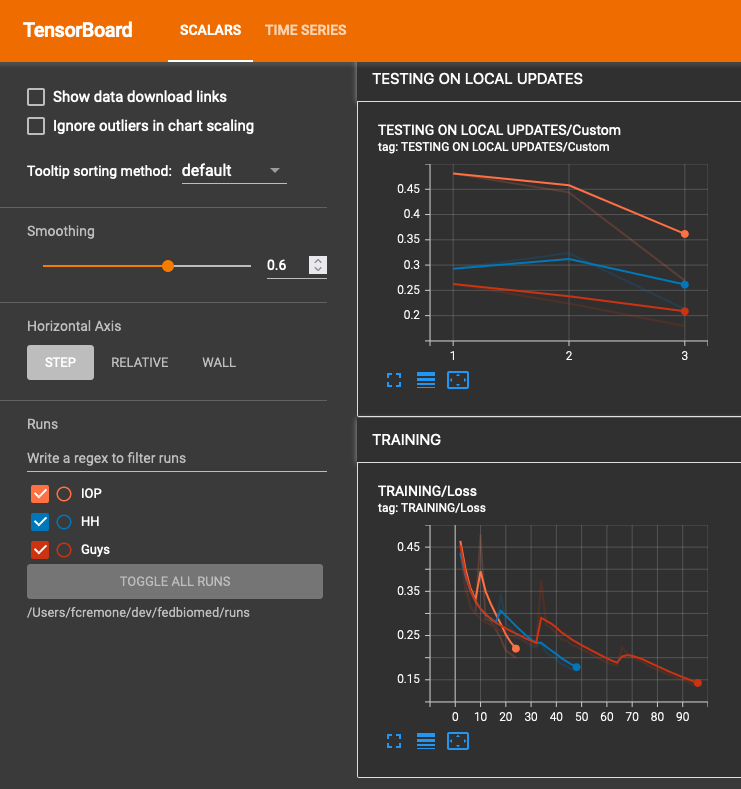

## Run the experiment

In [ ]:
exp.run_once(increase=True)

Save trained model to file

In [ ]:
exp.training_plan().export_model('./trained_model')

## Validate on a local holdout set

To ensure consistency and simplify our life, we try to reuse the already-available code as much as possible. Note that this process assumes that the held-out data is stored locally on the machine. 

### Create an instance of the global model
First, we create an instance of the model using the parameters from the latest aggregation round.

In [ ]:
local_training_plan = UNetTrainingPlan()
local_model = local_training_plan.init_model(model_args)

In [ ]:
for dependency_statement in local_training_plan.init_dependencies():
    exec(dependency_statement)

In [ ]:
local_model.load_state_dict(exp.aggregated_params()[exp.round_current()-1]['params'])

### Define a validation data loader

We extract the validation data loader from the training plan as well. This requires some knowledge about the internals of the `MedicalFolderDataset` class. At the end of the process, calling the `split` function with a ratio of 0 will return a data loader that loads all of the data.

In [ ]:
from fedbiomed.researcher.config import config
from torch.utils.data import DataLoader
import os
from fedbiomed.common.dataset_types import DataReturnFormat
import torch

researcher_path = os.path.dirname(config.root)
data_loaders = []

datasets = [{
    'dataset_parameters': {
        'root' : f'{researcher_path}/guys/data/holdout/',
        'tabular_file': f'{researcher_path}/guys/data/holdout/participants.csv',
        'index_col': 14
        }
    },
    {
    'dataset_parameters': {
        'root' : f'{researcher_path}/hh/data/holdout/',
        'tabular_file': f'{researcher_path}/hh/data/holdout/participants.csv',
        'index_col': 14
        }
    },
    {
    'dataset_parameters': {
        'root' : f'{researcher_path}/iop/data/holdout/',
        'tabular_file': f'{researcher_path}/iop/data/holdout/participants.csv',
        'index_col': 14
        }
    },
]


for dataset in datasets:
    val_data_manager = local_training_plan.training_data()
    val_data_manager._dataset.complete_initialization(controller_kwargs=(dataset['dataset_parameters']), to_format=DataReturnFormat.TORCH)
    data_loaders.append(DataLoader(val_data_manager._dataset))

### Compute the loss on validation images

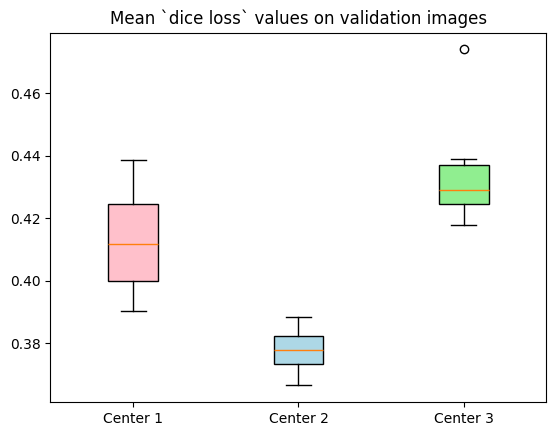

In [14]:
import torch
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d


local_model.eval()
losses = []
labels = []

for i, dl in enumerate(data_loaders):
    
    losses_ = []
    labels.append(f"Center {i+1}")
    with torch.no_grad():
        for i, batch in enumerate(dl):
            image = batch[0]['T1']
            target = batch[1]['label']
            prediction = local_model.forward(image)
            loss = UNetTrainingPlan.get_dice_loss(prediction, target)
            losses_.append(loss.mean())
    losses.append(losses_)

    
plt.subplot(111)    
bxplt = plt.boxplot(losses,
                    vert=True,
                    patch_artist=True)   
plt.title("Mean `dice loss` values on validation images") 
plt.gca().xaxis.set_ticklabels(labels)

colors = ['pink', 'lightblue', 'lightgreen']
for patch, color in zip(bxplt['boxes'], colors):
        patch.set_facecolor(color) 
plt.show()

### Visualize Training Loss and Testing Metrics 

In [ ]:
# Visualize training loss

import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d


monitor = exp.monitor()
metrics = monitor._metric_store


training_metrics = [('training', k) for k in list(metrics[list(metrics.keys())[0]]['training'].keys())]
testing_global_metrics = [('testing_global_updates', k) for k in list(metrics[list(metrics.keys())[0]]['testing_global_updates'].keys())]
testing_local_metrics = [('testing_local_updates', k) for k in list(metrics[list(metrics.keys())[0]]['testing_local_updates'].keys())]


metrics_ = [*training_metrics, *testing_local_metrics, *testing_global_metrics]

cols = len(metrics_)


fig, axes = plt.subplots(1, cols, figsize=( cols * 4, len(metrics) * 1.5))

for i, (node, store) in enumerate(metrics.items()):
    
    title = ""
    for k, (for_, m_) in enumerate(metrics_):
        
        title = f"Metrics {for_}" if title != f"Metrics {for_}" else title
        data = [i  for k, l in store[for_].get(m_, {}).items() for i in l["values"]]
        smoothed = gaussian_filter1d(data, sigma=1.5)
        axes[k].plot(smoothed, label=f"Node {i+1}")
        axes[k].set_title(title)
        axes[k].set_ylabel(m_)
        axes[k].set_xlabel("Iterations")
        axes[k].legend()
        
fig.tight_layout()
plt.show()


### Visualize Predictions

As a bonus, we visualize the outputs of our model on the holdout dataset. 

In [ ]:
val_data_loader = data_loaders[0]
one_batch = next(iter(val_data_loader))

`one_batch` contains both input features and labels. Both are 3D images, which can be accessed in the following way (`k` represents the _height_ in the stack of images):

In [ ]:
k = 24
one_batch[1]['label'][..., k].shape

In [ ]:
k = 24
one_batch[0]['T1'][..., k].shape

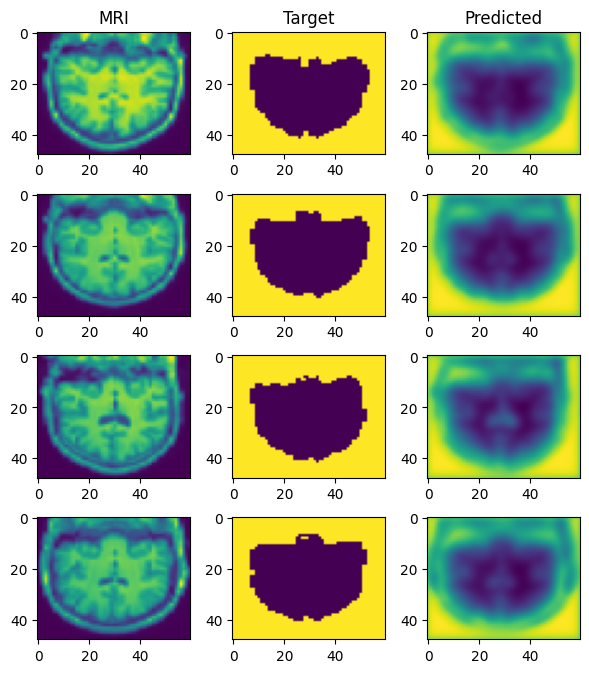

In [19]:
import matplotlib.pyplot as plt


# Display only layer 24 of 3D image
k = 24
max_samples = 4
fig, axes = plt.subplots(max_samples, 3, figsize=(6, max_samples * 1.7 ))


# Set labels
axes[0][0].set_title("MRI")
axes[0][1].set_title("Target")
axes[0][2].set_title("Predicted")
    
for b, batch in enumerate(val_data_loader):
    
    if b >= max_samples:
        break
    
    mri = batch[0]['T1']
    target = batch[1]['label']

    with torch.no_grad():
        prediction = local_model.forward(mri)
 
    image_mri = mri[0, 0, ..., k]
    axes[b][0].imshow(image_mri)
    
    image_target = target[0, 0, ..., k] 
    axes[b][1].imshow(image_target)

    pred = prediction[0, 0, ..., k]
    axes[b][2].imshow(pred)
    
    
fig.tight_layout()
plt.show()
    